# Training of the _Rich_ model for _pions_

In this notebook we setup the training for the Rich model for _pions_, based on Generative Adversarial Networks (GAN).

This notebook is part of a pipeline and requires the data preprocessed with the notebook [Rich-preprocessing.ipynb](./Rich-preprocessing.ipynb).

In [1]:
LOCAL = True
SAMPLE = "2016MU"

## Enviornment setup and libraries

In this notebooks we will use the standard software stack for TensorFlow machine learning applications.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import environ

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

To ensure a GPU is found and properly loaded in the notebook kernel to the benefit of TensorFlow, the output of the following block should be similar to `'/device:GPU:0'`.
If a GPU is not found, the string will be empty.

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Load datasets

Preprocessed datasets were stored in *Apache feather* format and can be reloaded with our custom `FeatherReader` designed to stream the datasets into TensorFlow or Dask format.

We are loading in particular:
 * the **training** dataset to train the network
 * the **validation** dataset to evaluate the network performance at each epoch and identify overtraining effects

In [4]:
DATA_PATH = "/home/mabarbet/PythonFastSim/data" if LOCAL else "/workarea/cloud-storage/mabarbet/data"

In [5]:
from feather_io import FeatherReader    

reader_train = FeatherReader(environ.get("RICH_PION_TRAIN_DATA", f"{DATA_PATH}/Rich-pion-{SAMPLE}-train"), max_files=4)
ds_train = reader_train.as_tf_dataset()

reader_val = FeatherReader(environ.get("RICH_PION_VAL_DATA", f"{DATA_PATH}/Rich-pion-{SAMPLE}-validation"), max_files=1)
ds_val = reader_val.as_tf_dataset()

We load a small batch of data to identify the shape of features and labels, and automate the definition of the neural network architecture.

In [6]:
x_vars = reader_train.features
y_vars = reader_train.labels

x_vars, y_vars

(['p_GeV', 'eta', 'nTracks_f', 'charge'],
 ['RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLp'])

In [7]:
X, y = next(iter(ds_train.batch(500_000)))
X.shape, y.shape

(TensorShape([500000, 4]), TensorShape([500000, 4]))

## Model definition

TBA

### Generator architecture

TBA

In [8]:
from pidgan.players.generators import ResGenerator

generator = ResGenerator(
    output_dim=y.shape[1],
    latent_dim=64,
    num_hidden_layers=10,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    output_activation=None,
    name="generator",
)

In [9]:
generator(X[:256])
generator.summary()

Model: "generator_func"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 68)]                 0         []                            
                                                                                                  
 dense_0 (Dense)             (None, 128)                  8832      ['input_1[0][0]']             
                                                                                                  
 leaky_relu_0 (LeakyReLU)    (None, 128)                  0         ['dense_0[0][0]']             
                                                                                                  
 dropout_0 (Dropout)         (None, 128)                  0         ['leaky_relu_0[0][0]']        
                                                                                     

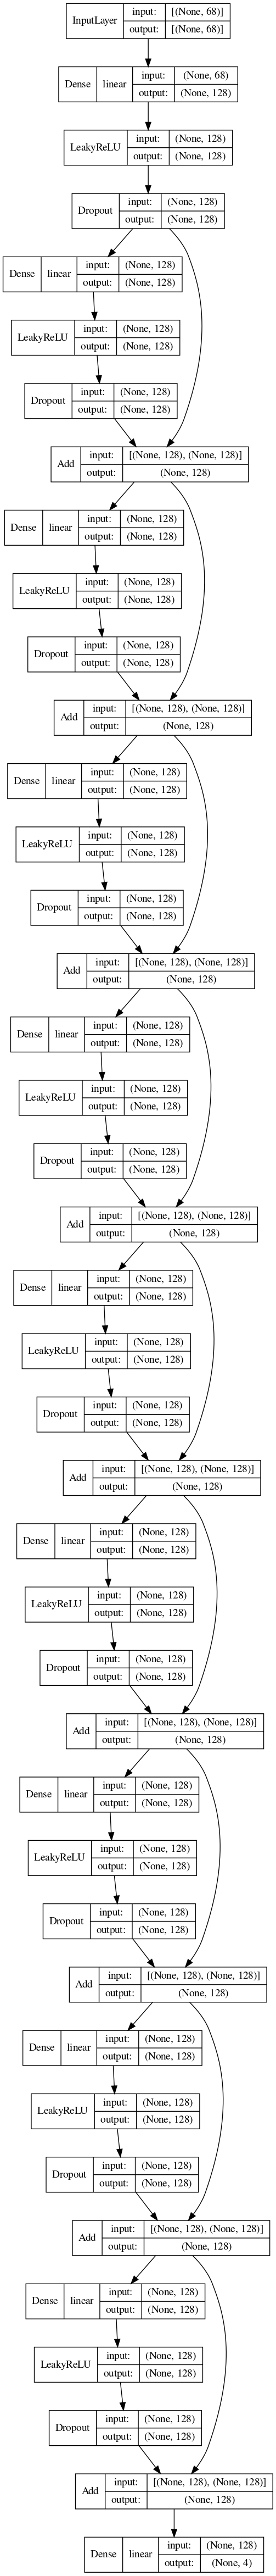

In [10]:
tf.keras.utils.plot_model(
    generator.export_model,
    to_file="./images/Rich-pion-generator.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
    rankdir="TB",
    dpi=100,
)

### Discriminator architecture

TBA

In [11]:
from pidgan.players.discriminators import AuxDiscriminator

discriminator = AuxDiscriminator(
    output_dim=1,
    aux_features=[
        f"{y_vars.index('RichDLLmu')} - {y_vars.index('RichDLLe')}",
        f"{y_vars.index('RichDLLp')} - {y_vars.index('RichDLLk')}",
    ],
    num_hidden_layers=10,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    enable_residual_blocks=True,
    output_activation="sigmoid",
    name="discriminator",
)

In [12]:
discriminator((X[:256], y[:256]))
discriminator.summary()

Model: "discriminator_func"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 dense_0 (Dense)             (None, 128)                  1408      ['input_2[0][0]']             
                                                                                                  
 leaky_relu_0 (LeakyReLU)    (None, 128)                  0         ['dense_0[0][0]']             
                                                                                                  
 dropout_0 (Dropout)         (None, 128)                  0         ['leaky_relu_0[0][0]']        
                                                                                 

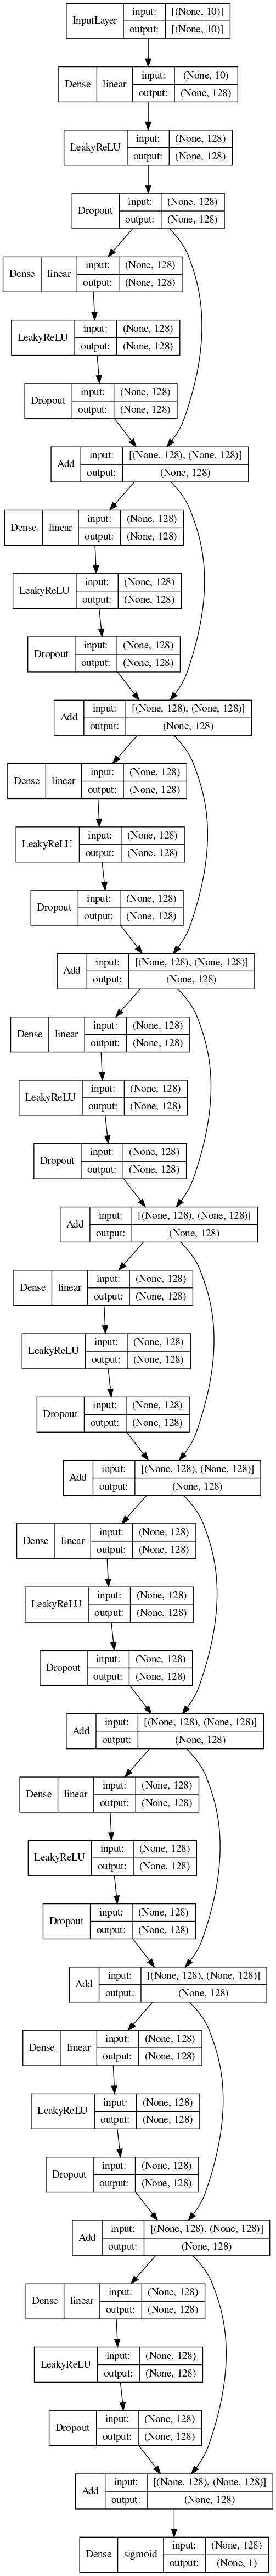

In [13]:
tf.keras.utils.plot_model(
    discriminator.export_model,
    to_file="./images/Rich-pion-discriminator.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
    rankdir="TB",
    dpi=100,
)

### Referee architecture

In [14]:
from pidgan.players.classifiers import Classifier

referee = Classifier(
    num_hidden_layers=5,
    mlp_hidden_units=128,
    mlp_hidden_activation="relu",
    mlp_hidden_kernel_regularizer=None,
    mlp_dropout_rates=0.0,
    name="referee",
)

In [15]:
referee((X[:256], y[:256]))
referee.summary()

Model: "referee_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (256, 128)                1152      
                                                                 
 dropout_0 (Dropout)         (256, 128)                0         
                                                                 
 dense_1 (Dense)             (256, 128)                16512     
                                                                 
 dropout_1 (Dropout)         (256, 128)                0         
                                                                 
 dense_2 (Dense)             (256, 128)                16512     
                                                                 
 dropout_2 (Dropout)         (256, 128)                0         
                                                                 
 dense_3 (Dense)             (256, 128)                

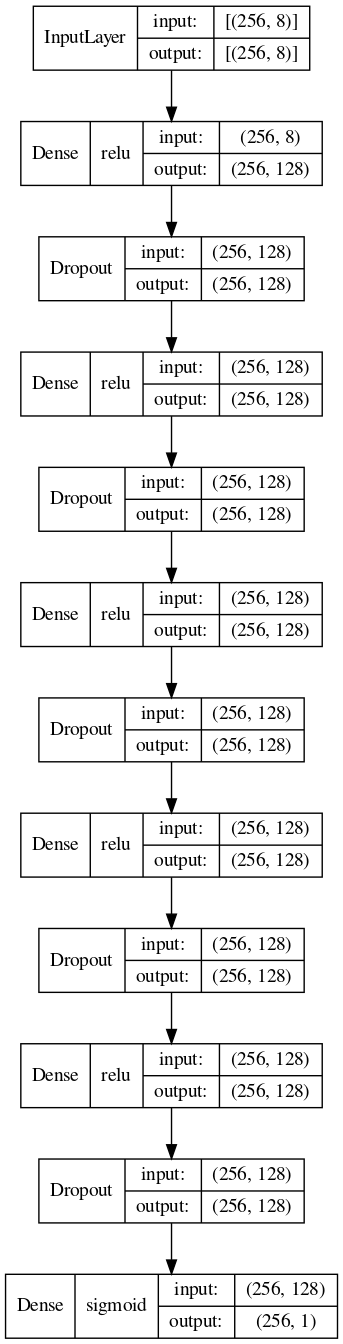

In [16]:
tf.keras.utils.plot_model(
    referee.export_model,
    to_file="./images/Rich-pion-referee.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
    rankdir="TB",
    dpi=100,
)

### Training setup

TBA

In [17]:
from pidgan.algorithms import BceGAN

gan = BceGAN(
    generator=generator,
    discriminator=discriminator,
    from_logits=False,
    label_smoothing=0.05,
    injected_noise_stddev=0.02,
    feature_matching_penalty=0.0,
    referee=referee,
)

In [18]:
from tensorflow.keras.optimizers import RMSprop, Adam

gan.compile(
    metrics=["accuracy", "js_div"],
    generator_optimizer=RMSprop(1e-4),
    discriminator_optimizer=RMSprop(1e-4),
    generator_upds_per_batch=1,
    discriminator_upds_per_batch=1,
    referee_optimizer=Adam(1e-3),
    referee_upds_per_batch=1,
)

In [19]:
from pidgan.callbacks.schedulers import LearnRateExpDecay

callbacks = list()

g_lr_sched = LearnRateExpDecay(
    gan.generator_optimizer,
    decay_rate=0.1,
    decay_steps=150_000,
    verbose=True,
    key="g_lr",
)
callbacks.append(g_lr_sched)

d_lr_sched = LearnRateExpDecay(
    gan.discriminator_optimizer,
    decay_rate=0.1,
    decay_steps=150_000,
    verbose=True,
    key="d_lr",
)
callbacks.append(d_lr_sched)

r_lr_sched = LearnRateExpDecay(
    gan.referee_optimizer,
    decay_rate=0.1,
    decay_steps=100_000,
    verbose=True,
    key="r_lr",
)
callbacks.append(r_lr_sched)

In [20]:
from datetime import datetime

batch_size = 10_000
num_epochs = 500

data_train = ds_train.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
data_val = next(iter(ds_val.batch(batch_size)))

train = gan.fit(data_train, epochs=num_epochs, validation_data=data_val, callbacks=callbacks)

prefix = ""
timestamp = str(datetime.now())
timestamp = timestamp.split(".")[0].replace("-", "").replace(" ", "-")
for time, unit in zip(timestamp.split(":"), ["h", "m", "s"]):
    prefix += time + unit  # YYYYMMDD-HHhMMmSSs

Epoch 1/500
      6/Unknown - 13s 22ms/step - g_loss: 17.6314 - d_loss: 4.0272 - r_loss: 0.4366 - accuracy: 0.4690 - js_div: 1.2839 - g_lr: 9.9996e-05 - d_lr: 9.9996e-05 - r_lr: 9.9994e-04WARNING:tensorflow:Callback method `on_train_batch_begin` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_begin` time: 0.0947s). Check your callbacks.
861/861 [==============================] - 38s 28ms/step - g_loss: 3.0428 - d_loss: 0.3808 - r_loss: 0.1378 - accuracy: 0.1505 - js_div: 0.8114 - g_lr: 9.9342e-05 - d_lr: 9.9342e-05 - r_lr: 9.9015e-04 - val_g_loss: 3.3334 - val_d_loss: 0.3348 - val_r_loss: 0.1388 - val_accuracy: 0.1001 - val_js_div: 0.9380
Epoch 2/500
861/861 [==============================] - 21s 23ms/step - g_loss: 2.6342 - d_loss: 0.3818 - r_loss: 0.2117 - accuracy: 0.1795 - js_div: 0.7232 - g_lr: 9.8036e-05 - d_lr: 9.8036e-05 - r_lr: 9.7069e-04 - val_g_loss: 2.7713 - val_d_loss: 0.3886 - val_r_loss: 0.2061 - val_accuracy: 0.1167 - val_js_div: 0.7179
Epoch 

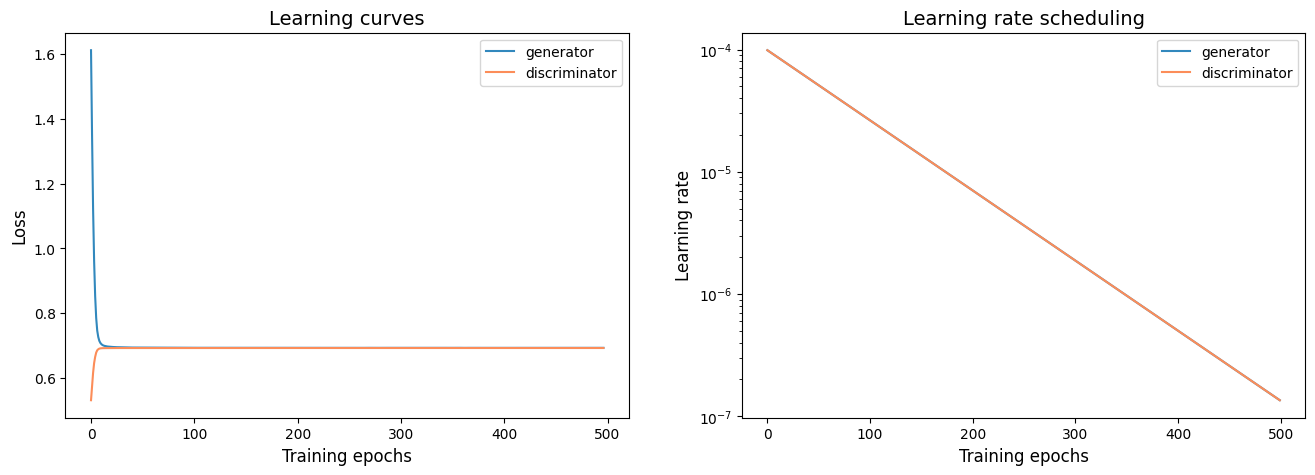

In [21]:
plt.figure(figsize=(16, 5), dpi=100)

start_epoch = 3

plt.subplot(1, 2, 1)
plt.title("Learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.plot(train.history["g_loss"][start_epoch:], color="#3288bd", label="generator")
plt.plot(train.history["d_loss"][start_epoch:], color="#fc8d59", label="discriminator")
# plt.plot(train.history["r_loss"], color="#4dac26", label="referee")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Learning rate scheduling", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Learning rate", fontsize=12)
plt.plot(train.history["g_lr"], color="#3288bd", label="generator")
plt.plot(train.history["d_lr"], color="#fc8d59", label="discriminator")
# plt.plot(train.history["r_lr"], color="#4dac26", label="referee")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.show()

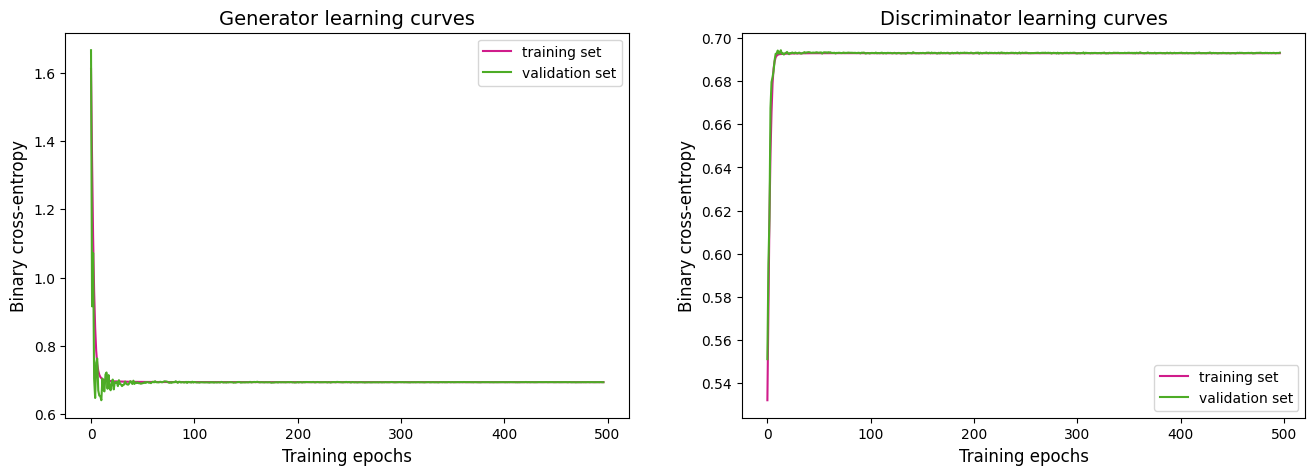

In [22]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Generator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["g_loss"][start_epoch:], color="#d01c8b", label="training set")
plt.plot(train.history["val_g_loss"][start_epoch:], color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Discriminator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["d_loss"][start_epoch:], color="#d01c8b", label="training set")
plt.plot(train.history["val_d_loss"][start_epoch:], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

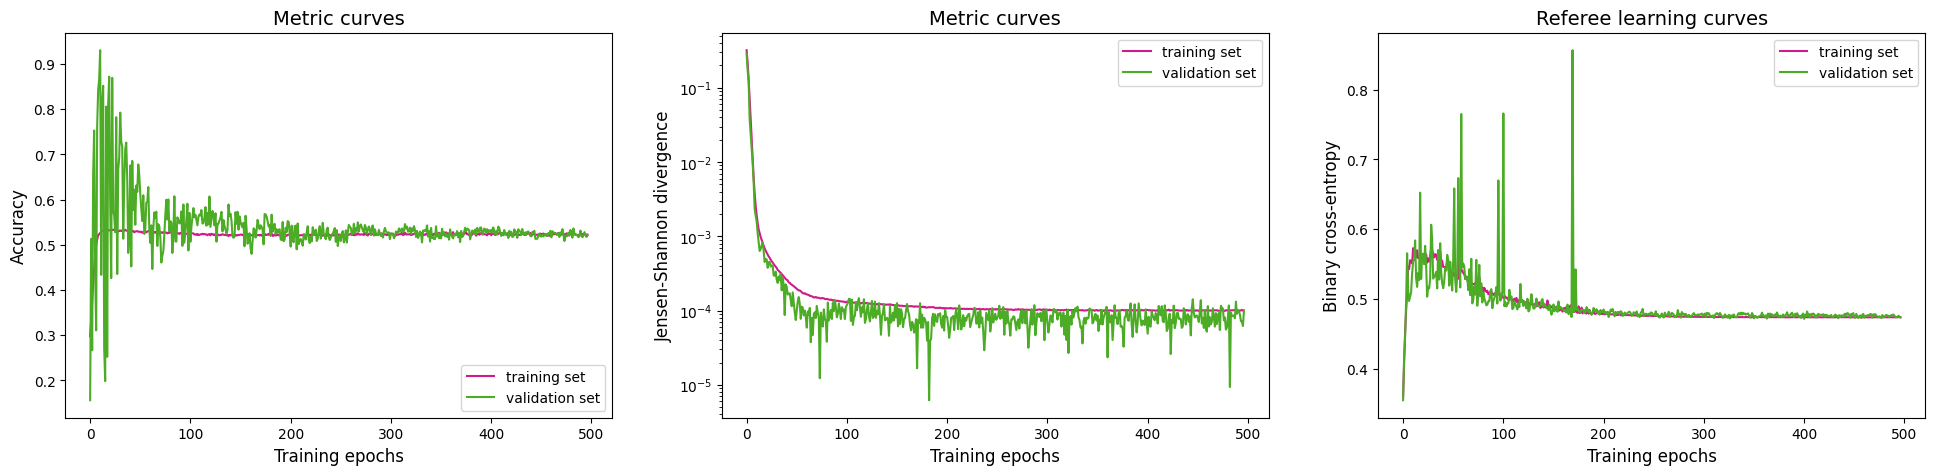

In [23]:
plt.figure(figsize=(24, 5), dpi=100)

plt.subplot(1, 3, 1)
plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.plot(train.history["accuracy"][start_epoch:], color="#d01c8b", label="training set")
plt.plot(train.history["val_accuracy"][start_epoch:], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.subplot(1, 3, 2)
plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Jensen-Shannon divergence", fontsize=12)
plt.plot(train.history["js_div"][start_epoch:], color="#d01c8b", label="training set")
plt.plot(train.history["val_js_div"][start_epoch:], color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.subplot(1, 3, 3)
plt.title("Referee learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Binary cross-entropy", fontsize=12)
plt.plot(train.history["r_loss"][start_epoch:], color="#d01c8b", label="training set")
plt.plot(train.history["val_r_loss"][start_epoch:], color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.show()

In [24]:
train_history = train.history.copy()
pd.DataFrame(train_history).to_csv(f"./exports/{prefix}-Rich-pion-train.csv")

## A first, rough validation

TBA

In [25]:
reader_test = FeatherReader(environ.get("RICH_PION_TEST_DATA", f"{DATA_PATH}/Rich-pion-{SAMPLE}-test"), max_files=50)
head = reader_test.as_dask_dataframe().head(20_000_000, npartitions=-1)

In [26]:
X_test = head[reader_test.features].values
y_test = head[reader_test.labels].values
preds = gan.generator.predict(X_test, batch_size=50_000)

400/400 [==============================] - 2s 5ms/step


In [27]:
X_test.shape, y_test.shape, preds.shape

((20000000, 4), (20000000, 4), (20000000, 4))

In [28]:
referee_true = gan.referee.predict((X_test, y_test), batch_size=50_000)
referee_pred = gan.referee.predict((X_test, preds), batch_size=50_000)

400/400 [==============================] - 1s 2ms/step


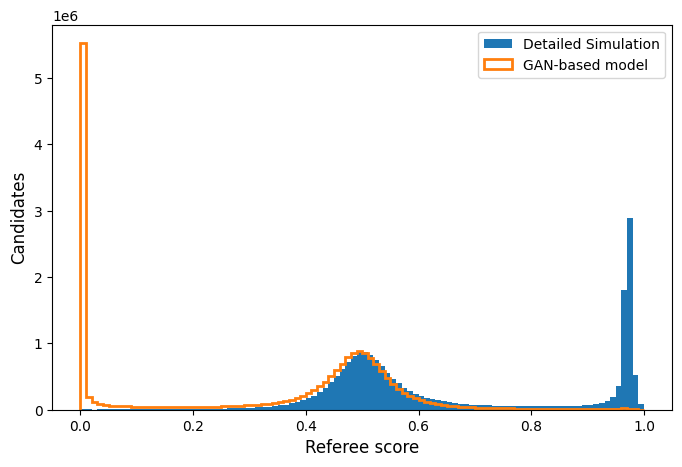

In [29]:
plt.figure(figsize=(8, 5), dpi=100)
plt.xlabel("Referee score", fontsize=12)
plt.ylabel("Candidates", fontsize=12)

bins = np.linspace(0.0, 1.0, 101)
plt.hist(referee_true, bins=bins, label="Detailed Simulation")
plt.hist(referee_pred, bins=bins, histtype="step", lw=2, label="GAN-based model")
plt.legend(fontsize=10)

plt.show()

In [30]:
from pidgan.optimization.scores import KSDistance

ks_dist = KSDistance()
ks_score = ks_dist(referee_true, referee_pred, bins=100, range=[0.0, 1.0])

print(f"K-S distance (referee): {ks_score:.3f}")

K-S distance (referee): 0.406


In [31]:
chunk_size = 5_000_000

np.savez_compressed(
    f"./exports/{prefix}-Rich-pion-referee.npz",
    referee_true=referee_true[:chunk_size],
    referee_pred=referee_pred[:chunk_size],
    ks_score=ks_score,
)

In [32]:
import pickle

models_dir = "/home/mabarbet/PythonFastSim/models/Rich_pion_models"

with open(f"{models_dir}/tX_{SAMPLE}.pkl", "rb") as file:
    X_scaler = pickle.load(file)

with open(f"{models_dir}/tY_{SAMPLE}.pkl", "rb") as file:
    y_scaler = pickle.load(file)

In [33]:
from pidgan.utils.preprocessing import invertColumnTransformer
    
X_post = invertColumnTransformer(X_scaler, X_test)
y_post = y_scaler.inverse_transform(y_test)
preds_post = y_scaler.inverse_transform(preds)

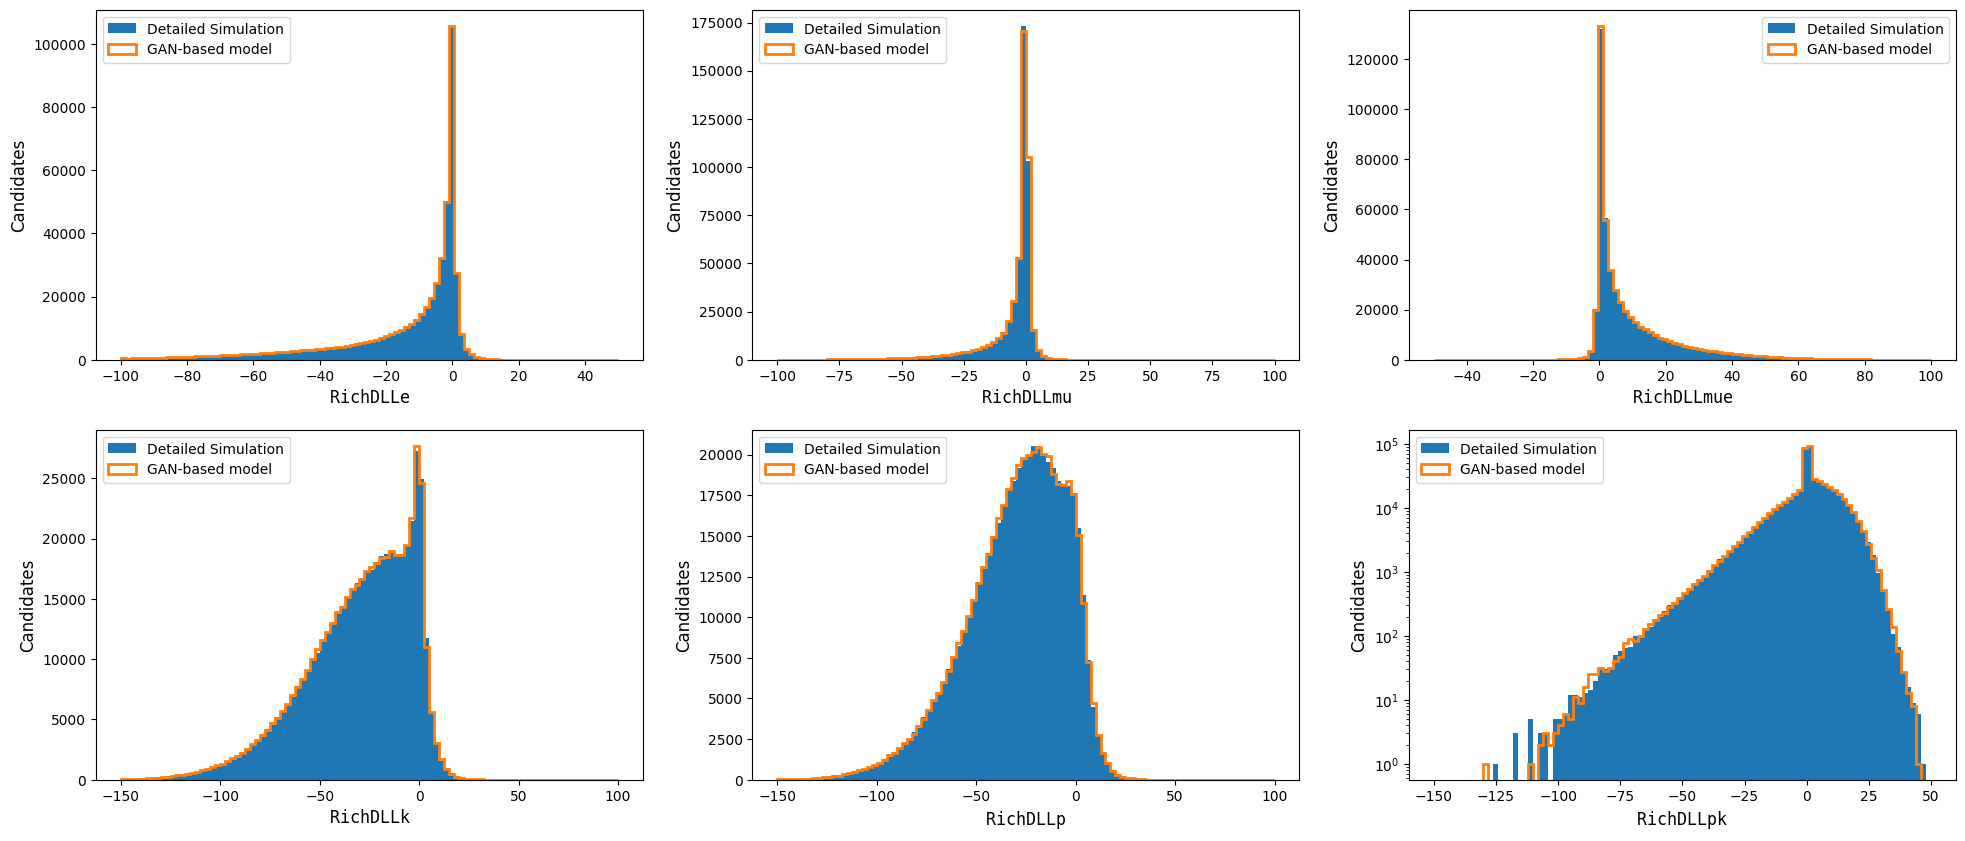

In [34]:
plt.figure(figsize=(24, 10), dpi=100)

# RichDLLe
plt.subplot(2, 3, 1)
bins = np.linspace(-100.0, 50.0, 101)
plt.xlabel("$\mathtt{RichDLLe}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(
    y_post[:, y_vars.index("RichDLLe")][:500000],
    bins=bins,
    label="Detailed Simulation",
)
plt.hist(
    preds_post[:, y_vars.index("RichDLLe")][:500000],
    bins=bins,
    histtype="step",
    lw=2, 
    label="GAN-based model",
)
plt.legend(loc="upper left", fontsize=10)

# RichDLLmu
plt.subplot(2, 3, 2)
bins = np.linspace(-100.0, 100.0, 101)
plt.xlabel("$\mathtt{RichDLLmu}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(
    y_post[:, y_vars.index("RichDLLmu")][:500000],
    bins=bins,
    label="Detailed Simulation",
)
plt.hist(
    preds_post[:, y_vars.index("RichDLLmu")][:500000],
    bins=bins,
    histtype="step",
    lw=2,
    label="GAN-based model",
)
plt.legend(loc="upper left", fontsize=10)

# RichDLLmue
plt.subplot(2, 3, 3)
bins = np.linspace(-50.0, 100.0, 101)
plt.xlabel("$\mathtt{RichDLLmue}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(
    y_post[:, y_vars.index("RichDLLmu")][:500000] - y_post[:, y_vars.index("RichDLLe")][:500000],
    bins=bins,
    label="Detailed Simulation",
)
plt.hist(
    preds_post[:, y_vars.index("RichDLLmu")][:500000] - preds_post[:, y_vars.index("RichDLLe")][:500000],
    bins=bins,
    histtype="step",
    lw=2,
    label="GAN-based model",
)
plt.legend(loc="upper right", fontsize=10)

# RichDLLk
plt.subplot(2, 3, 4)
bins = np.linspace(-150.0, 100.0, 101)
plt.xlabel("$\mathtt{RichDLLk}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(
    y_post[:, y_vars.index("RichDLLk")][:500000],
    bins=bins,
    label="Detailed Simulation",
)
plt.hist(
    preds_post[:, y_vars.index("RichDLLk")][:500000],
    bins=bins,
    histtype="step",
    lw=2,
    label="GAN-based model",
)
plt.legend(loc="upper left", fontsize=10)

# RichDLLp
plt.subplot(2, 3, 5)
bins = np.linspace(-150.0, 100.0, 101)
plt.xlabel("$\mathtt{RichDLLp}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(
    y_post[:, y_vars.index("RichDLLp")][:500000],
    bins=bins,
    label="Detailed Simulation",
)
plt.hist(
    preds_post[:, y_vars.index("RichDLLp")][:500000],
    bins=bins,
    histtype="step",
    lw=2,
    label="GAN-based model",
)
plt.legend(loc="upper left", fontsize=10)

# RichDLLpk
plt.subplot(2, 3, 6)
bins = np.linspace(-150.0, 50.0, 101)
plt.xlabel("$\mathtt{RichDLLpk}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(
    y_post[:, y_vars.index("RichDLLp")][:500000] - y_post[:, y_vars.index("RichDLLk")][:500000],
    bins=bins,
    label="Detailed Simulation",
)
plt.hist(
    preds_post[:, y_vars.index("RichDLLp")][:500000] - preds_post[:, y_vars.index("RichDLLk")][:500000],
    bins=bins,
    histtype="step",
    lw=2,
    label="GAN-based model",
)
plt.legend(loc="upper left", fontsize=10)
plt.yscale("log")

plt.show()

## Data and model export

To simplify the preparation of LHCb figures and freeze the results obtained, the output of the trained model is exported and NumPy file and then uploaded to GitLab.

In [35]:
np.savez_compressed(
    f"./exports/{prefix}-Rich-pion-results.npz",
    feat_vars=np.array(x_vars),
    label_vars=np.array(y_vars),
    results=np.c_[X_post, y_post, preds_post][:1_400_000],
)

Finally, we export the Keras model to the same folder where the preprocessing step was stored.

In [36]:
import os

default_output_model = f"{models_dir}/{prefix}_Rich_pion_{SAMPLE}_gan"
output_model = os.path.dirname(environ['OUTPUT_MODEL']) if 'OUTPUT_MODEL' in environ else default_output_model

base_dir = os.path.dirname(output_model)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

tf.keras.models.save_model(
    generator.export_model,
    filepath=output_model,
    save_format="tf",
)

INFO:tensorflow:Assets written to: /home/mabarbet/PythonFastSim/models/Rich_pion_models/20240102-01h01m14s_Rich_pion_2016MU_gan/assets


INFO:tensorflow:Assets written to: /home/mabarbet/PythonFastSim/models/Rich_pion_models/20240102-01h01m14s_Rich_pion_2016MU_gan/assets
